In [1]:
import matplotlib.pyplot as plt
from skimage.transform import warp
from scipy import misc
import numpy as np
import sys
import skimage.io as io
from skimage.draw import polygon

def process_data(name):
    filename = "data{}.txt".format(name)
    with open(filename) as file:
        data = file.readlines()[0]
    data = data[13:][:-2]
    data = data + ","
    data = data.replace(" ", "").split("[")[1:]
    data = [a.replace("],", "") for a in data]
    data = [a.split(",") for a in data]
    data = [[float(a[0]), float(a[1])] for a in data]
    print(len(data), "data points read from file")
    data = np.array(data)
    assert len(data) == 4
    return data

POINT_COUNT = 4

In [2]:
im_left = plt.imread("doe1.jpeg")
im_center = plt.imread("doe2.jpeg")

In [3]:
points1 = process_data("doe1W")
points2 = process_data("doe2W")

4 data points read from file
4 data points read from file


In [4]:
points1

array([[1534.36997465, 1218.0498008 ],
       [1534.36997465, 1510.11789207],
       [3453.67457443, 1181.54128939],
       [3453.67457443, 1648.32868526]])

In [5]:
points2

array([[ 375.4855125 , 1098.09326331],
       [ 375.4855125 , 1429.27761681],
       [2339.12187613, 1152.85603042],
       [2336.51412532, 1577.91941326]])

In [6]:
def computeHomographyMatrix(imA_points, imB_points):
    A = computeAMatrix(imA_points, imB_points)
    b = computeBVector(imB_points)

    result = np.linalg.lstsq(A, np.transpose(b))[0]
    return formatHMatrix(result)


def computeAMatrix(imA_points, imB_points):
    matrix_string = ""
    for i in range(POINT_COUNT):
        x, y = imA_points[i][0], imA_points[i][1]
        x_1, y_1 = imB_points[i][0], imB_points[i][1]
        if i + 1 == POINT_COUNT:
            value = "{} {} 1 0 0 0 {} {};".format(x, y, -1 * x * x_1, -1 * y * x_1) + "0 0 0 {} {} 1 {} {}".format(x, y,
                                                                                                                   -1 * x * y_1,
                                                                                                                   -1 * y * y_1)
            matrix_string += value
        else:
            value = "{} {} 1 0 0 0 {} {};".format(x, y, -1 * x * x_1, -1 * y * x_1) + "0 0 0 {} {} 1 {} {};".format(x,
                                                                                                                    y,
                                                                                                                    -1 * x * y_1,
                                                                                                                    -1 * y * y_1)
            matrix_string += value

    return np.matrix(matrix_string)


def computeBVector(imB_points):
    vector_string = ""
    for i in range(POINT_COUNT):
        x, y = imB_points[i][0], imB_points[i][1]
        vector_string += " {} {} ".format(x, y)

    return np.matrix(vector_string)


def formatHMatrix(result):
    H = np.matrix("{} {} {};".format(result[0], result[1], result[2])
                  + "{} {} {};".format(result[3], result[4], result[5])
                  + "{} {} 1".format(result[6], result[7]))
    return H

def linearBlend(imA, imB, weight):
    height, width = imA.shape[0], imA.shape[1]
    blendedIm = imA * (1 - weight) + imB * weight
    return np.clip(blendedIm, 0, 1)

In [7]:
H_LC = computeHomographyMatrix(points1, points2)
H_CC = computeHomographyMatrix(points2, points2)
H_CL = np.linalg.inv(H_LC)


# warpedImL = warp(im_left, np.linalg.inv(H_LC), output_shape=(im_left.shape[0] * 1.5, im_left.shape[1] * 3))
# warpedImC = warp(im_center, np.linalg.inv(H_CC), output_shape=(im_left.shape[0] * 1.5, im_left.shape[1] * 3))
# result = linearBlend(warpedImL, warpedImC, weight=.5)
# io.imsave("doe.jpg", result)

/Users/zixianzang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


In [8]:
im_left.shape

(3024, 4032, 3)

In [9]:
canvas = np.zeros((30000, 30000))

In [10]:
corleftup = np.array([0, 0])
corleftdown = np.array([3023, 0])
corrightdown = np.array([3023, 4031])
corrightup = np.array([0, 4031])

In [11]:
im_left[corleftdown[0], corleftdown[1]]
im_left[corleftup[0], corleftup[1]]
im_left[corrightdown[0], corrightdown[1]]
im_left[corrightup[0], corrightup[1]]

array([176, 189, 205], dtype=uint8)

In [12]:
p = np.array(H_LC @ np.array([points1[0][0], points1[0][1], 1]))
p/p[0][2]

array([[3.7548324e+02, 1.0980866e+03, 1.0000000e+00]])

In [13]:
"""Points passed in should not stacked with 1, returned one is without 1"""
def transfer(points, H):
    shape = points.shape[0]
    ones = np.ones((shape, 1))
    Xs = np.array(points[:, 0:1])
    Ys = np.array(points[:, 1:])
    stacked = np.stack([Xs, Ys, ones], axis = 1)
    transfered = np.array(H @ stacked)
    weights = np.stack([transfered[:,2],transfered[:,2], transfered[:,2]], axis = 1)
    normalized = transfered/weights
    return normalized[:, :2]

transfer(points1, H_LC)

array([[ 375.48324039, 1098.08660159],
       [ 375.48324295, 1429.26895507],
       [2339.09621897, 1152.8433802 ],
       [2336.48853101, 1577.9021223 ]])

In [14]:
corners = np.array([corleftup, corleftdown, corrightdown, corrightup])
transfer(corners, H_LC)

array([[-2.06688732e+03, -7.39719773e+02],
       [ 1.97442507e+03,  3.56643723e+00],
       [ 1.95537782e+03,  3.83010165e+03],
       [-2.02401651e+03,  4.91171575e+03]])

In [15]:
new_corners = transfer(np.array([[0, 0],[0, 3023],[4031, 3023], [4031, 0]]), H_LC)

In [16]:
area = polygon(np.array([0, 0, 4032, 4032]), np.array([0, 3023, 3023, 0]))

In [17]:
imagearea = np.stack([area[0], area[1]], axis = 1)

In [18]:
resultarea = transfer(imagearea, H_LC).astype(np.int32)
resultarea


array([[-2066,  -739],
       [-2066,  -738],
       [-2066,  -736],
       ...,
       [ 2775,  2749],
       [ 2775,  2750],
       [ 2775,  2751]], dtype=int32)

In [19]:
canvas = np.zeros((5000, 5000))

resultx = resultarea[:, 1]
resulty = resultarea[:, 0]
resultx = ((np.abs(resultx) + resultx)/2).astype(np.int32)
resulty = ((np.abs(resulty) + resulty)/2).astype(np.int32)
canvas[resultx, resulty] = 255

In [20]:
new_corners = transfer(np.array([[0, 0],[0, 3023],[4031, 3023], [4031, 0]]), H_LC).astype(np.int32)
new_poly = polygon(np.array([new_corners[0][1], new_corners[1][1], new_corners[2][1], new_corners[3][1]]),
                  np.array([new_corners[0][0], new_corners[1][0], new_corners[2][0], new_corners[3][0]]))

In [21]:
canvas = np.zeros((5000, 5000, 3))
canvas[new_poly[0],new_poly[1]] = 255

/Users/zixianzang/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


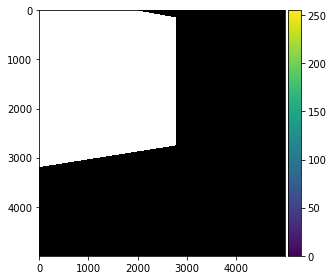

In [22]:
io.imshow(canvas)

In [23]:
canvas = np.zeros((5000, 5000, 3))
new_positions = np.array([new_poly[1], new_poly[0]]).T
new_positions.shape
map_to_oringin = transfer(new_positions, H_CL).astype(np.int32)

In [24]:
canvas[new_poly[0],new_poly[1]] = im_left[map_to_oringin[:, 1], map_to_oringin[:, 0]]

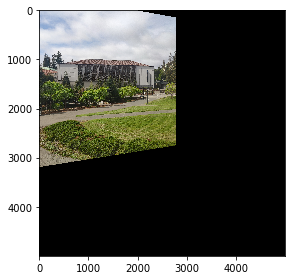

In [25]:
io.imshow(canvas/255)

In [26]:
map_to_oringin[:, 1].shape

(8214937,)

In [27]:
io.imsave("shift.jpg", canvas)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


In [28]:
def tocenter(Cimg, Cpoints, otherImg, otherPoints):
    H_toC = computeHomographyMatrix(otherPoints, Cpoints)
    print(H_toC)
    H_fromC = np.linalg.inv(H_toC)
    origin_Shape = Cimg.shape
    canvas = np.zeros((origin_Shape[0]*2, origin_Shape[1]*2, 3))
    new_corners = transfer(np.array([[0, 0],[0, 3023],[4031, 3023], [4031, 0]]), H_toC).astype(np.int32)
    new_poly = polygon(np.array([new_corners[0][1], new_corners[1][1], new_corners[2][1], new_corners[3][1]]),
                       np.array([new_corners[0][0], new_corners[1][0], new_corners[2][0], new_corners[3][0]]))
    new_positions = np.array([new_poly[1], new_poly[0]]).T
    map_to_oringin = transfer(new_positions, H_fromC).astype(np.int32)
    print(np.max(map_to_oringin[:, 1]), np.max(map_to_oringin[:, 0]))
    canvas[new_poly[0],new_poly[1]] = otherImg[map_to_oringin[:, 1], map_to_oringin[:, 0]]
    return canvas

def tocenter_H(Cimg, otherImg, H_toC):
    H_fromC = np.linalg.inv(H_toC)
    origin_Shape = Cimg.shape
    canvas = np.zeros((origin_Shape[0]*2, origin_Shape[1]*2, 3))
    new_corners = transfer(np.array([[0, 0],[0, 3023],[4031, 3023], [4031, 0]]), H_toC).astype(np.int32)
    new_poly = polygon(np.array([new_corners[0][1], new_corners[1][1], new_corners[2][1], new_corners[3][1]]),
                       np.array([new_corners[0][0], new_corners[1][0], new_corners[2][0], new_corners[3][0]]))
    new_positions = np.array([new_poly[1], new_poly[0]]).T
    map_to_oringin = transfer(new_positions, H_fromC).astype(np.int32)
    print(np.max(map_to_oringin[:, 1]), np.max(map_to_oringin[:, 0]))
    canvas[new_poly[0],new_poly[1]] = otherImg[map_to_oringin[:, 1], map_to_oringin[:, 0]]
    return canvas

resultL = tocenter(im_center, points2, im_left, points1)
resultR = tocenter(im_center, points2, im_center, points2)
resultTogether = linearBlend(resultL, resultR, .5)

/Users/zixianzang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


[[ 1.65163750e+00  1.66426000e-03 -2.06688732e+03]
 [ 2.46445610e-01  1.42376356e+00 -7.39719773e+02]
 [ 1.59430000e-04  4.43228580e-06  1.00000000e+00]]
3022 4030
[[ 1.00000000e+00  2.19309488e-15 -3.83722484e-12]
 [ 2.51782524e-15  1.00000000e+00 -6.18623917e-12]
 [ 1.52156966e-18  2.89432314e-18  1.00000000e+00]]
3021 4029


In [29]:
io.imsave("blend.jpg", resultR)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


In [30]:
np.max(resultR)

255.0

In [31]:
import matplotlib.pyplot as plt
import skimage.io as skio
from skimage.transform import warp
from scipy import misc
import numpy as np
import sys
import harris
import math
import random

In [32]:
im_left = io.imread("doe1.jpeg")
im_left_bw = io.imread("doe1.jpeg", as_gray=True)
im_right = io.imread("doe2.jpeg")
im_right_bw = io.imread("doe2.jpeg", as_gray=True)
H_left, coors_left = harris.get_harris_corners(im_left_bw)
H_right, coors_right = harris.get_harris_corners(im_right_bw)

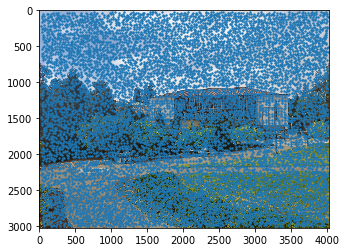

In [33]:
plt.imshow(im_left)
plt.scatter(coors_left[1][:], coors_left[0][:], s = 2)
plt.savefig("plotdoe1.jpg", quality = 100)

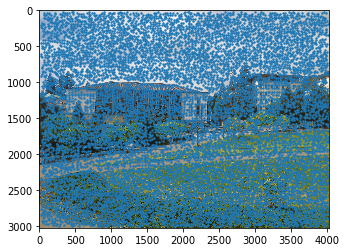

In [34]:
plt.imshow(im_right)
plt.scatter(coors_right[1][:], coors_right[0][:], s = 2)
plt.savefig("plotdoe2.jpg", quality = 100)

In [35]:
def ANMS(points, eps, H):
	radius_values = {}
	for center in points:
		H_i = H[center[0], center[1]]
		interest_points = []
		for point in points:
			H_j = H[point[0], point[1]]
			if H_i < (eps * H_j):
				interest_points.append(point)
		if len(interest_points) > 0:
			radius_values[center] = np.amin(harris.dist2(np.array([center]), np.array(interest_points)))
	radius_values = sorted(((value, key) for (key, value) in radius_values.items()), reverse = True)
	
	top_500 = [[], []]
	for i in range(500):
		top_500[0].append(radius_values[i][1][0])
		top_500[1].append(radius_values[i][1][1])

	return top_500

In [36]:
points_left = []
ANMS_points_left = []
for i in range(len(coors_left[0])):
    points_left.append((coors_left[0][i], coors_left[1][i]))
ANMS_coors_left = ANMS(points_left, .9, H_left)

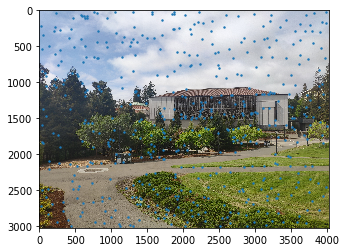

In [54]:
plt.imshow(im_left)
plt.scatter(ANMS_coors_left[1], ANMS_coors_left[0], s = 2)
plt.savefig("ANMSdoe1.jpg", quality = 100)

In [38]:
points_right = []
ANMS_points_right = []
for i in range(len(coors_right[0])):
    points_right.append((coors_right[0][i], coors_right[1][i]))
ANMS_coors_right = ANMS(points_right, .9, H_right)

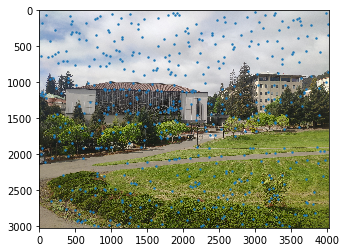

In [55]:
plt.imshow(im_right)
plt.scatter(ANMS_coors_right[1], ANMS_coors_right[0], s = 2)
plt.savefig("ANMSdoe2.jpg", quality = 100)

In [40]:
import skimage
def find_descriptors(im, points):
    results = {}
    patch_size = 40
    for point in points:
        corner_left_x = point[0] - 20
        corner_left_y = point[1] - 20
        sample_patch = np.zeros((40, 40))
        for i in range(patch_size):
            for j in range(patch_size):
                pixel = im[corner_left_x + i][corner_left_y + j]
                sample_patch[i][j] = pixel

        #subsample_patch = misc.imresize(sample_patch, (8, 8))
        subsample_patch = skimage.transform.resize(sample_patch, (8, 8))
        mean = np.mean(subsample_patch)
        std = np.std(subsample_patch)
        normalized_patch = (subsample_patch - mean)/std

        results[point] = np.reshape(normalized_patch, (1, 64))
    return results

In [41]:
for i in range(len(ANMS_coors_left[0])):
    ANMS_points_left.append((ANMS_coors_left[0][i], ANMS_coors_left[1][i]))
descriptors_left = find_descriptors(im_left_bw, ANMS_points_left)

for i in range(len(ANMS_coors_right[0])):
    ANMS_points_right.append((ANMS_coors_right[0][i], ANMS_coors_right[1][i]))
descriptors_right = find_descriptors(im_right_bw, ANMS_points_right)

In [42]:
def feature_match(desc_imA, desc_imB):
	results = {}
	for point_A, vector_A in desc_imA.items():
		dists = {}
		for point_B, vector_B in desc_imB.items():
			dists[point_B] = harris.dist2(vector_A, vector_B)[0][0]
		dists = sorted((value, key) for (key, value) in dists.items())

		if dists[0][0]/dists[1][0] < .3:
			results[point_A] = dists[0][1]
	return results
matched_features = feature_match(descriptors_left, descriptors_right)

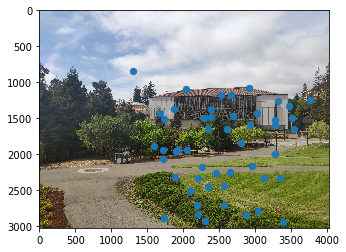

In [56]:
matched_left_points = list(matched_features.keys())
plt.imshow(im_left)
plt.scatter([x for (y, x) in matched_left_points], [y for (y, x) in matched_left_points], s = 40)
plt.savefig("Featuredoe1.jpg", quality = 100)

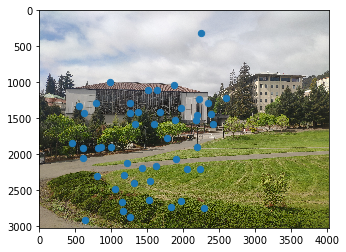

In [57]:
matched_right_points = list(matched_features.values())
plt.imshow(im_right)
plt.scatter([x for (y, x) in matched_right_points], [y for (y, x) in matched_right_points], s = 40)
plt.savefig("Featuredoe2.jpg", quality = 100)

In [45]:
def RANSAC(matched_points):
    points_A = list(matched_points.keys())
    points_B = list(matched_points.values())
    results = {}
    sub_points = random.sample(range(1, len(points_A)), 4)
    subpoints_A = np.array([points_A[sub_points[0]], points_A[sub_points[1]], points_A[sub_points[2]], points_A[sub_points[3]]])
    subpoints_B = np.array([points_B[sub_points[0]], points_B[sub_points[1]], points_B[sub_points[2]], points_B[sub_points[3]]])

    H = computeHomographyMatrix(subpoints_A, subpoints_B)
    b = np.array(points_B)

    error = np.dot(H, np.transpose(np.hstack((points_A, np.ones((len(points_A), 1))))))	
    A = np.zeros(error.shape)
    for i in range(3):
        A[i, :] = error[i, :] /error[2, :]

    A = np.transpose(A)[:,:2]
    val_1 = (A[:,0] - b[:,0])**2
    val_2 = (A[:,1] - b[:,1])**2
    sqrd_err = np.sqrt(val_1 + val_2)

    for i in range(len(sqrd_err)):
#         print(sqrd_err[i])
        if sqrd_err[i] < 0.5:
            results[points_A[i]] = points_B[i]
    return results

In [46]:
RANSAC_points = {}
for i in range(1000):
    points = RANSAC(matched_features)
    if len(points) > len(RANSAC_points):
        RANSAC_points = points

leftpoints = list(RANSAC_points.keys()) 
rightpoints = list(RANSAC_points.values())

leftswitch = []
for p in leftpoints:
    leftswitch.append((p[1], p[0]))
    
rightswitch = []
for p in rightpoints:
    rightswitch.append((p[1], p[0]))
        
        
H_L = computeHomographyMatrix(leftswitch, rightswitch)
H_R = computeHomographyMatrix(rightswitch, rightswitch)

/Users/zixianzang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


In [47]:
def linearBlend(imA, imB, weight):
    height, width = imA.shape[0], imA.shape[1]
    blendedIm = np.zeros((imA.shape))
    blendedIm = imA * (1 - weight) + imB * weight

    return blendedIm

In [51]:

resultL = tocenter_H(im_right, im_left, H_L)
resultR = tocenter_H(im_right, im_right, H_R)
result = linearBlend(resultL, resultR, 0.5)

3022 4030
3021 4029


In [52]:
np.max(resultR)

255.0

In [53]:
io.imsave("Center.jpg",result)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


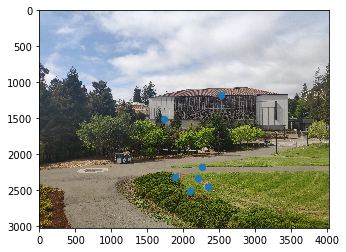

In [58]:
plt.imshow(im_left)
plt.scatter([x for (y, x) in leftpoints], [y for (y, x) in leftpoints], s = 40)
plt.savefig("doe1RAN.jpg", quality = 100)

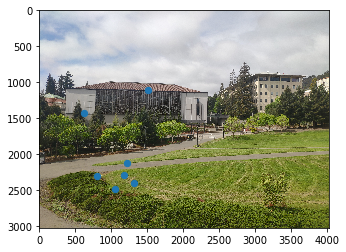

In [59]:
plt.imshow(im_right)
plt.scatter([x for (y, x) in rightpoints], [y for (y, x) in rightpoints], s = 40)
plt.savefig("doe2RAN.jpg", quality = 100)

In [ ]:
H_L

In [ ]:
H_LC

In [ ]:
H_L = computeHomographyMatrix(leftpoints, rightpoints)

In [ ]:
leftpoints

In [ ]:
leftswitch = []
for p in leftpoints:
    leftswitch.append((p[1], p[0]))
    
rightswitch = []
for p in rightpoints:
    rightswitch.append((p[1], p[0]))

In [ ]:
HS_L = computeHomographyMatrix(leftswitch, rightswitch)

In [ ]:
HS_L